## IFT870 - TP1 
### gibg2501 - leba3207
#### 7 février 2020

In [1]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell


# removes maximum number of columns & rows for display
pd.options.display.max_columns = 7
pd.options.display.max_rows = 10

# show every output in every cell
InteractiveShell.ast_node_interactivity = "all" #    'all', 'last', 'last_expr', 'none', 'last_expr_or_assign'

# Loads the data
tp1_data_file = 'TP1_data.csv'
tp1_data = pd.read_csv(tp1_data_file, header=0, index_col=0)
tp1_data

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0
...,...,...,...,...,...
id55,68.5,19.2,0.3,12.0,2
id56,59.5,21.4,0.2,13.5,2
id57,65.8,27.0,0.2,6.7,2
id58,66.1,19.6,0.7,10.8,2


Description des données statistiques de base du jeux de données

In [2]:
tp1_data.describe()

,attribut1,attribut2,attribut3,attribut4,classe
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627,0.915254
std,10.490782,3.531995,8.174992,4.057994,0.815542
min,28.700000,16.500000,0.000000,3.700000,0.000000
25%,40.850000,21.050000,2.400000,12.000000,0.000000
50%,49.000000,23.300000,9.000000,15.100000,1.000000
75%,59.200000,25.100000,13.000000,16.950000,2.000000
max,68.500000,33.000000,29.100000,23.000000,2.000000


Affichage des attributs du jeux de données paire à paire et quantification de la correlation à l'aide de la méthode de Pearson $$\left(\frac{cov(X,Y)}{\sigma_X\sigma_Y} \right)$$

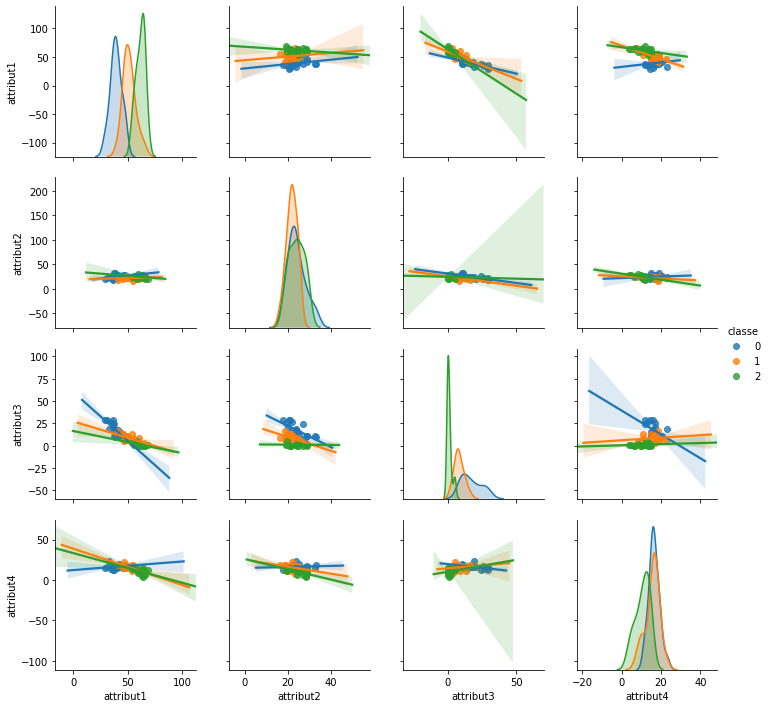

In [3]:
%matplotlib inline
sns.pairplot(tp1_data, vars=['attribut1', 'attribut2', 'attribut3', 'attribut4'],  hue='classe', kind='reg')

condition0 = tp1_data['classe'] == 0
condition1 = tp1_data['classe'] == 1
condition2 = tp1_data['classe'] == 2

tp1_data_classe_0 = tp1_data.loc[condition0 , 'attribut1':'attribut4']
tp1_data_classe_1 = tp1_data.loc[condition1 , 'attribut1':'attribut4']
tp1_data_classe_2 = tp1_data.loc[condition2 , 'attribut1':'attribut4']

Corrélation inter-attributs pour la classe 0 

In [4]:
tp1_data_classe_0.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.302290,-0.784024,0.205335
attribut2,0.302290,1.000000,-0.671647,0.097789
attribut3,-0.784024,-0.671647,1.000000,-0.496368
attribut4,0.205335,0.097789,-0.496368,1.000000


Corrélation inter-attributs pour la classe 1

In [5]:
tp1_data_classe_1.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.137804,-0.590792,-0.726196
attribut2,0.137804,1.000000,-0.543282,-0.303635
attribut3,-0.590792,-0.543282,1.000000,0.142723
attribut4,-0.726196,-0.303635,0.142723,1.000000


Corrélation inter-attributs pour la classe 2

In [6]:
tp1_data_classe_2.corr(method='pearson')

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,-0.213961,-0.620437,-0.427720
attribut2,-0.213961,1.000000,-0.035696,-0.621881
attribut3,-0.620437,-0.035696,1.000000,0.136993
attribut4,-0.427720,-0.621881,0.136993,1.000000


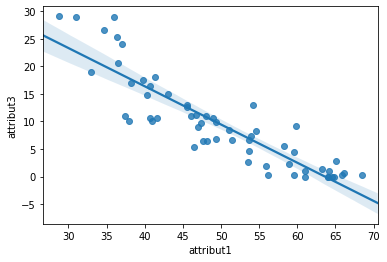

In [7]:
sns.regplot(tp1_data.loc[:,'attribut1'],tp1_data.loc[:,'attribut3'])

## Q1
a) Les relations de corrélations sont visiblement différentes pour les 3 classes.
Par exemple, pour la classe 0 le 1er et le 3e, ainsi que le 2e et 3e attributs sont fortement et négativement corrélés.
Les attributs 3 et 4 sont encore négativement corrélés, mais beausoup plus faiblement. Ces corrélations ne tiennent cependant plus pour la classe 1 et 2.


Utilisation de la méthode de réduction en composantes principales ($$\textit{PCA}$$) pour quantifier les corrélations entre les attributs pour chaque classe

In [8]:
# Scale the features data
scaler = StandardScaler()
features = tp1_data.loc[: , 'attribut1':'attribut4']
labels = tp1_data.loc[: , 'classe']
scaler.fit(features)
tp1_data_scaled = scaler.transform(features)

# Apply PCA on data set features
PCA_data_tp1 = PCA(n_components =  features.shape[1])
PCA_data_tp1.fit(tp1_data_scaled, labels)
tp1_data_transf = PCA_data_tp1.transform(tp1_data_scaled)

data_tp1_components = pd.DataFrame(PCA_data_tp1.components_, columns=list(features.columns))
tp1_components_ratios = PCA_data_tp1.explained_variance_ratio_

data_tp1_components

md('Les variances pour toutes les sont: {}'.format(tp1_components_ratios))

StandardScaler(copy=True, with_mean=True, with_std=True)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

,attribut1,attribut2,attribut3,attribut4
0,0.616124,0.208019,-0.584117,-0.485723
1,-0.314208,0.939914,0.087324,-0.101042
2,-0.081104,-0.165542,0.538960,-0.821913
3,-0.717696,-0.214210,-0.600586,-0.279863


Les variances pour toutes les sont: [0.58532927 0.24909152 0.16140426 0.00417495]

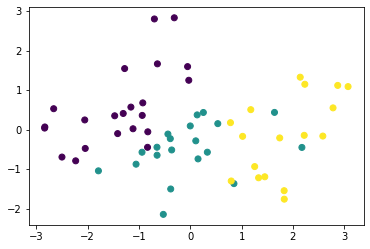

In [20]:
# Dipslay transformed features in 2D & 3D
plt.scatter(tp1_data_transf[:, 0], tp1_data_transf[:, 1], c = labels)

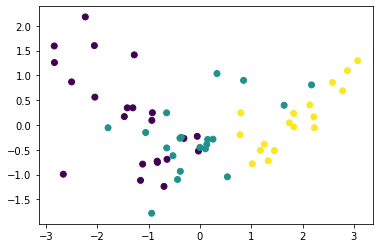

In [19]:
plt.scatter(tp1_data_transf[:, 0], tp1_data_transf[:, 2], c = labels)

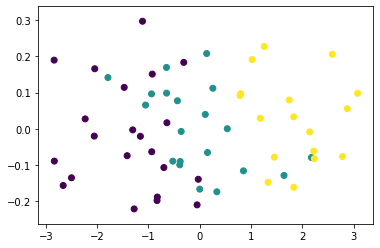

In [18]:
plt.scatter(tp1_data_transf[:, 0], tp1_data_transf[:, 3], c = labels)